In [1]:
!pip install triton==2.0.0.dev20221005

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Introduction

PyTorch is one of the prominent Deep Learning Frameworks. It ships with a lot of useful operators and modules for building and training your own Deep Learning model. However, in certain cases, you can write your own CUDA kernels for certain operations to improve performance. 

In this blog, we are going to try `Triton`, a Python Framework, which helps us to write efficient CUDA kernels at runtime and use them to improve our performance. We will then use this `Triton` kernel to override one of the existing operator kernel in PyTorch. Thus we don't have to write our model code any different (from the PyTorch API) and yet we will see performance boost.

In [2]:
import torch
import triton
import triton.language as tl

### Enter Triton

Triton is a language and compiler which enables us as Python user to write and generate blazingly fast CUDA kernels at run-time and use them. Writing an efficient GPU kernel is not a trivial task as one has to ensure that memory and compute are being utilized efficiently.

This [blog](https://openai.com/blog/triton/) walks us through the idea and architecture of Triton.

#### Writing a CUDA kernel for `sin` using Triton

In [3]:
# `sin` CUDA kernel
@triton.jit
def _sin(x_ptr, output_ptr,
        BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Load data
    x = tl.load(x_ptr + offsets)
    output = tl.sin(x)
    # Write-back output
    tl.store(output_ptr + offsets, output)


def triton_sin(x):
    output = torch.empty_like(x)
    assert x.is_contiguous()
    n_elements = x.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    # Launch `sin` kernel
    _sin[grid](x, output, BLOCK_SIZE=256)
    return output

Check for simple correctness of our kernel

In [4]:
# Input tensor
x = torch.randn(size=(1024, 1024)).cuda()

# Verify that our outputs match with the PyTorch's output
torch.testing.assert_close(triton_sin(x), torch.sin(x))

#### Benchmark `torch` implementation vs Triton

In [5]:
# Helper for benchmarking
# Benchmark `torch.sin` vs `triton_sin`
def run_benchmark():
    @triton.testing.perf_report(
        triton.testing.Benchmark(
            x_names=['N'],  # argument names to use as an x-axis for the plot
            x_vals=[
                128 * i for i in range(2, 100)
            ],  # different possible values for `x_name`
            line_arg='provider',  # argument name whose value corresponds to a different line in the plot
            line_vals=[
                'triton',
                'torch-native',
            ],  # possible values for `line_arg``
            line_names=[
                "Triton",
                "Torch (native)",
            ],  # label name for the lines
            styles=[('blue', '-'), ('green', '-')],  # line styles
            ylabel="GB/s",  # label name for the y-axis
            plot_name="sin-performance",  # name for the plot. Used also as a file name for saving the plot.
            args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
        )
    )
    def benchmark(M, N, provider):
        x = torch.randn(M, N, device='cuda', dtype=torch.float32)
        if provider == 'torch-native':
            ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.sin(x))
        if provider == 'triton':
            ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_sin(x))
        gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
        return gbps(ms), gbps(max_ms), gbps(min_ms)

    benchmark.run(show_plots=True, print_data=True)


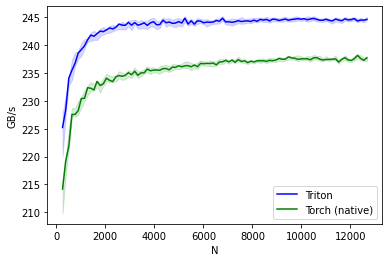

sin-performance:
          N      Triton  Torch (native)
0     256.0  225.209619      214.169933
1     384.0  228.348438      219.183942
2     512.0  234.057137      221.873883
3     640.0  235.486884      227.555552
4     768.0  236.734503      227.555555
..      ...         ...             ...
93  12160.0  244.729560      237.557995
94  12288.0  244.309408      238.143598
95  12416.0  244.480894      237.600154
96  12544.0  244.458198      237.265059
97  12672.0  244.597226      237.697202

[98 rows x 3 columns]


In [6]:
run_benchmark()

Based on the graph above, we can see that the Triton kernel has better performance than the native PyTorch kernel for the given input sizes.

### Let's replace PyTorch's CUDA kernel with Triton Kernel

#### Enter torch.library.Library

Doc: https://pytorch.org/docs/stable/library.html?highlight=library#torch.library.Library

PyTorch provides a mechanism to easily define and implement kernels for operators via Python. This also allow us to update `torch.sin` to always dispatch to the Triton generated kernel for tensor on CUDA device.

In [7]:
lib = torch.library.Library("aten", "IMPL", "CUDA")

#### We should get a warning notifying us that we are overriding an existing kernel!

In [8]:
# Henceforth, all calls to `torch.sin` with CUDA tensor will be dispatched
# to our Triton generated kernel. To verify, we should see no difference
# between `torch.sin` vs `triton_sin` in terms of performance.
lib.impl('sin', triton_sin)

/usr/local/lib/python3.7/dist-packages/torch/library.py:62: UserWarning: Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::sin(Tensor self) -> (Tensor)
    registered at aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: CUDA
  previous kernel: registered at ../aten/src/ATen/BatchingRegistrations.cpp:1068
       new kernel: registered at /dev/null:3326 (Triggered internally at  ../aten/src/ATen/core/dispatch/OperatorEntry.cpp:127.)
  self.m.impl(name, dispatch_key, fn)


### Re-run the benchmark, PyTorch native and triton version should have same performance now.

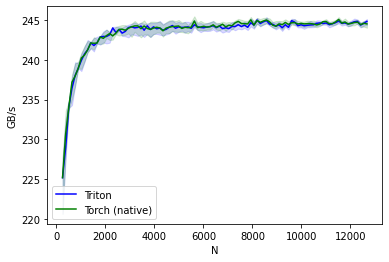

sin-performance:
          N      Triton  Torch (native)
0     256.0  225.209619      225.209619
1     384.0  229.013391      230.760556
2     512.0  234.057137      234.057137
3     640.0  236.421363      237.191451
4     768.0  238.024212      237.952192
..      ...         ...             ...
93  12160.0  244.782484      244.681476
94  12288.0  244.829934      244.725169
95  12416.0  244.358712      244.415079
96  12544.0  244.569898      244.586188
97  12672.0  244.832607      244.505061

[98 rows x 3 columns]


In [9]:
run_benchmark()

And we still get the automatic differentiation on the overridden operator for free

In [10]:
x = torch.randn(10, device='cuda', requires_grad=True)
y = x.sin()
y.sum().backward()

with torch.no_grad():
    torch.testing.assert_close(x.grad, x.cos())

### Conclusion

* We saw that Triton allows us to write efficient CUDA kernels very easily in Python. 
* We also used `torch.library.Library` to override the PyTorch's implementation with ours. This way, we can just override the kernels and get performance boost on existing models.

References:
1. https://openai.com/blog/triton/
2. https://triton-lang.org/master/index.html
3. https://pytorch.org/docs/stable/library.html#torch-library